### DiBS marginal inference of $p(G | D)$ for linear Gaussian Bayes nets with BGe marginal likelihood

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(G | D)$ or $p(G, \Theta | D)$ using off-the-shelf inference methods such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [1]:
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np

key = random.PRNGKey(123)
print(f"JAX backend: {jax.default_backend()}")

JAX backend: cpu


### Generate synthetic ground truth Bayesian network and BN model for inference

`data` contains information about and observations sampled from a synthetic, ground truth causal model with `n_vars` variables. By default, the conditional distributions are linear Gaussian. The random graph model is set by `graph_prior_str`, where `er` denotes Erdos-Renyi and `sf` scale-free graphs. 

`graph_model` defines prior $p(G)$ and `likelihood_model` defines  *marginal*  likelihood $p(x | G )$ of the BN model for which DiBS will infer the posterior.


**For joint posterior inference, e.g., for inference of nonlinear Bayes net models, refer to the other example notebook `dibs_joint.ipynb`.** 


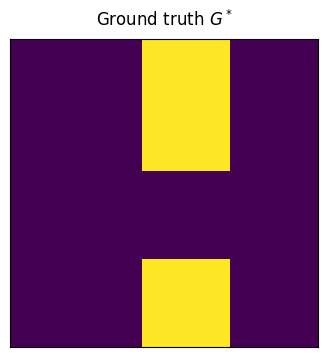

In [ ]:
from dibs.target import make_linear_gaussian_equivalent_model
from dibs.utils import visualize_ground_truth

key, subk = random.split(key)
_, graph_model, likelihood_model = make_linear_gaussian_equivalent_model(key=subk, n_vars=7, graph_prior_str="er")

data = jnp.array(np.load('./datasets/7var/data.npy'))
g = jnp.array(np.load('./datasets/7var/G.npy'))

N = data.shape[0]
N_train = int(0.7 * N)
data, data_ho = data[:N_train, :], data[N_train:, :]

visualize_ground_truth(g)

### DiBS with SVGD

Infer $p(G | D)$ under the prior and marginal likelihood defined by the model.
The below visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$ during the iterations of SVGD with DiBS. Refer to the paper for further details.

To explicitly perform joint posterior inference of $p(G, \Theta | D)$ using a general likelihood $p(x | G, \Theta)$, use the separate, analogous class `JointDiBS`.



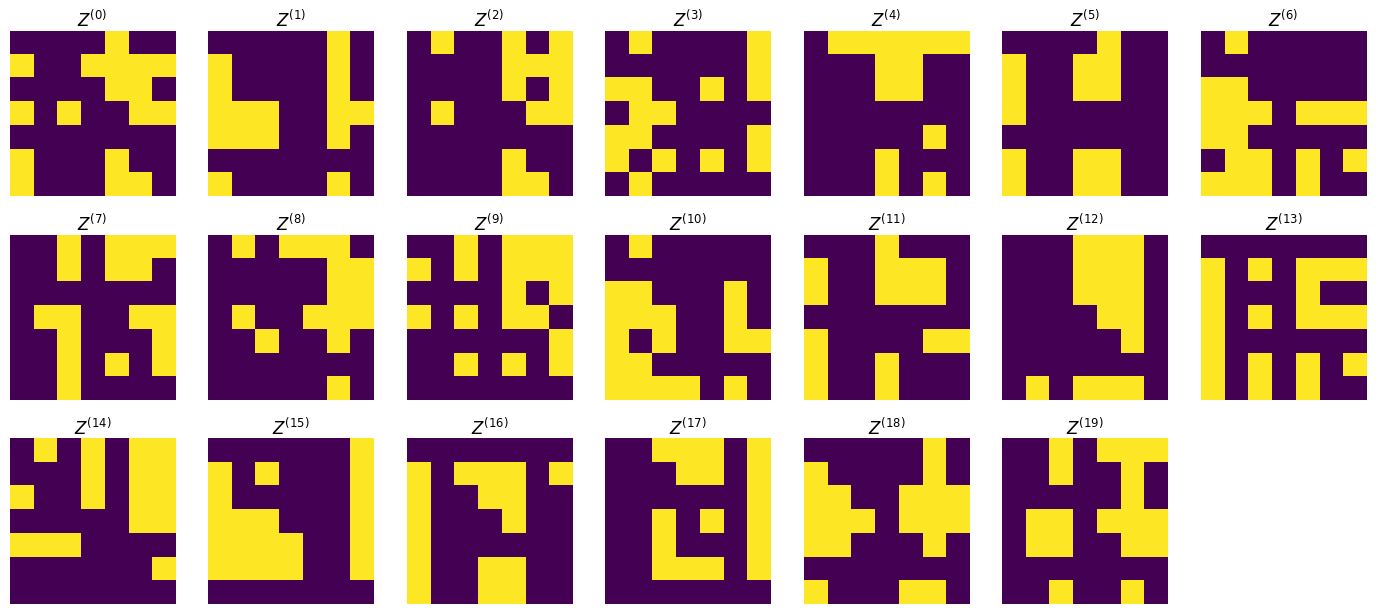

iteration   2000 | alpha 2000.0 | beta 2000.0 | #cyclic   1
CPU times: user 6min 58s, sys: 30.2 s, total: 7min 28s
Wall time: 4min 29s


In [3]:
%%time
from dibs.inference import MarginalDiBS

dibs = MarginalDiBS(x=data, interv_mask=None, graph_model=graph_model, likelihood_model=likelihood_model)
key, subk = random.split(key)
gs = dibs.sample(key=subk, n_particles=20, steps=2000, callback_every=20, callback=dibs.visualize_callback())

### Evaluate on held-out data

Form the empirical (i.e., weighted by counts) and mixture distributions (i.e., weighted by unnormalized posterior probabilities, denoted DiBS+).

In [4]:
dibs_empirical = dibs.get_empirical(gs)
dibs_mixture = dibs.get_mixture(gs)

Compute some evaluation metrics.

In [8]:
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_marginal_likelihood

for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:
    
    eshd = expected_shd(dist=dist, g=g)        
    auroc = threshold_metrics(dist=dist, g=g)['roc_auc']
    negll = neg_ave_log_marginal_likelihood(dist=dist, x=data_ho,
                eltwise_log_marginal_likelihood=dibs.eltwise_log_marginal_likelihood_observ)
    
    print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. MLL {negll:5.2f}')
    

DiBS  |  E-SHD: 13.8    AUROC:  0.61    neg. MLL 1393.03
DiBS+ |  E-SHD:  5.0    AUROC:  0.94    neg. MLL 1287.10
